In [2]:
# !pip install xclim 

In [5]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *

In [6]:
bc_dtr = read_gcs_zarr('gs://biascorrected-492e989a/stage/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/day/dtr/gn/v20211230093107.zarr')

In [7]:
bc_dtr

,Array,Chunk
Bytes,5.73 GiB,513.28 kiB
Shape,"(23725, 180, 360)","(73, 10, 180)"
Count,11701 Tasks,11700 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.73 GiB,513.28 kiB
Shape,"(23725, 180, 360)","(73, 10, 180)"
Count,11701 Tasks,11700 Chunks
Type,float32,numpy.ndarray


In [8]:
# define off the rails lat/lon 
target_lat = 70.5
target_lon = 41.5

extract bias corrected DTR and quantiles for this gridcell at all time points 

In [10]:
bc_dtr_gc = bc_dtr['dtr'].sel(lon=target_lon, lat=target_lat, method="nearest").load()

In [11]:
bc_q_gc = bc_dtr['sim_q'].sel(lon=target_lon, lat=target_lat, method="nearest").load()

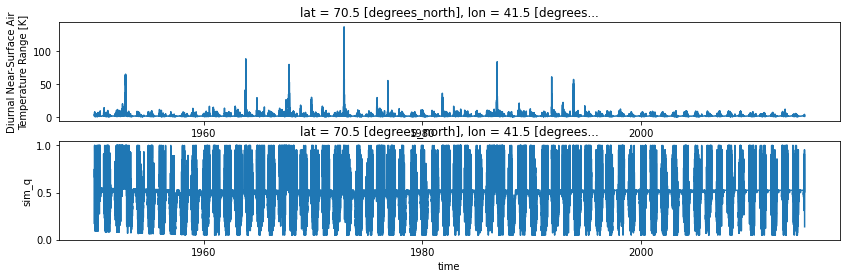

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(14, 4))
bc_dtr_gc.plot(ax=axes[0])

bc_q_gc.plot(ax=axes[1])

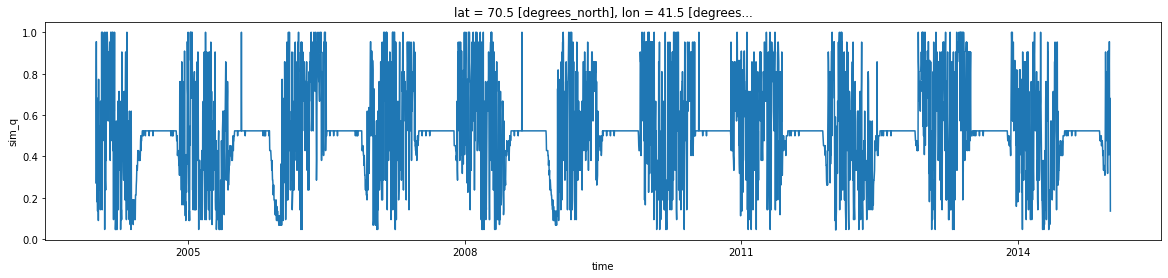

In [21]:
plt.figure(figsize=(20, 4))
bc_q_gc.sel(time=slice("2004", "2014")).plot()

what's the quantile at which the crazy high max value is occurring? 

In [23]:
bc_dtr_gc.argmax()

<xarray.DataArray 'dtr' ()>
array(8340)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5

In [24]:
bc_q_gc[8340]

<xarray.DataArray 'sim_q' ()>
array(1., dtype=float32)
Coordinates:
    lat      float64 70.5
    lon      float64 41.5
    time     object 1972-11-07 12:00:00

like we thought it's the extrapolated quantile (which prints as 1, assume it's rounded up)

let's look at the actual quantiles we _want_ to compute by loading a trained model from this same run

In [25]:
qdm_model_dtr = read_gcs_zarr('gs://scratch-170cd6ec/643c4b73-399d-427a-87be-cc0ab1b401d9/e2e-bcc-csm2-mr-dtr-qxg22-231454005/qdm_model.zarr')

In [27]:
qdm_model_dtr.quantiles

<xarray.DataArray 'quantiles' (quantiles: 100)>
array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095,
       0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175, 0.185, 0.195,
       0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275, 0.285, 0.295,
       0.305, 0.315, 0.325, 0.335, 0.345, 0.355, 0.365, 0.375, 0.385, 0.395,
       0.405, 0.415, 0.425, 0.435, 0.445, 0.455, 0.465, 0.475, 0.485, 0.495,
       0.505, 0.515, 0.525, 0.535, 0.545, 0.555, 0.565, 0.575, 0.585, 0.595,
       0.605, 0.615, 0.625, 0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695,
       0.705, 0.715, 0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795,
       0.805, 0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895,
       0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985, 0.995])
Coordinates:
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995

how many days in our time series do we have where we are actually using an AF for this quantile 

Text(0.5, 1.0, 'number of days with extrapolated quantile is 947.0')

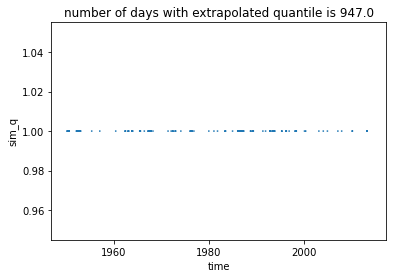

In [40]:
bc_q_gc.where(bc_q_gc > qdm_model_dtr.quantiles.max().values).plot()
plt.title('number of days with extrapolated quantile is {}'.format(bc_q_gc.where(bc_q_gc > qdm_model_dtr.quantiles.max().values).sum().values))

note we can't actually look at the AFs for this extrapolated quantile, bc they're extrapolated in the adjust step on the fly. But we can look at our most extreme ones 

In [47]:
afs = qdm_model_dtr['af'].sel(lon=target_lon, lat=target_lat, method="nearest").sel(quantiles=0.995).load()

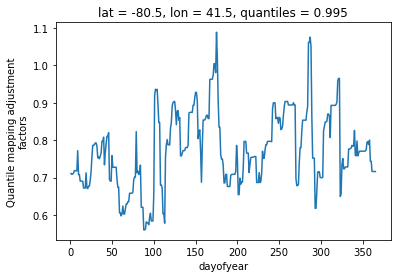

In [48]:
afs.plot()